In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jaidalmotra/weed-detection")
print("Path to dataset files:", path)

/Users/oceanspiess/PycharmProjects/ml-cv/ml-cv-project/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Path to dataset files: /Users/oceanspiess/.cache/kagglehub/datasets/jaidalmotra/weed-detection/versions/1


In [22]:
# Importation des bibliothèques
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import albumentations as A
import json
import shutil
import yaml
import cv2
import os
from ultralytics import YOLO
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, RandomFlip, RandomRotation, RandomZoom, Dropout
from tensorflow.keras import layers  
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical


# YOLO 

In [3]:
# Define paths for train and test data
train_folder = os.path.join(path, 'train')
test_folder = os.path.join(path, 'test')


In [4]:
def convert_to_yolo_format(coco_annotations, image_folder, output_folder):
    """
    Convert COCO annotations to YOLO format
    YOLO format: <class> <x_center> <y_center> <width> <height>
    Values are normalized between 0 and 1
    """
    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)
    
    # Create mapping of image_id to file_name and dimensions
    image_info = {}
    for img in coco_annotations['images']:
        image_info[img['id']] = {
            'file_name': img['file_name'],
            'width': img['width'],
            'height': img['height']
        }
    
    # Process each annotation
    current_image_id = None
    current_labels = []
    
    for ann in coco_annotations['annotations']:
        img_id = ann['image_id']
        img_data = image_info[img_id]
        
        # Get bbox coordinates
        x, y, w, h = ann['bbox']
        
        # Convert to YOLO format (normalized)
        x_center = (x + w/2) / img_data['width']
        y_center = (y + h/2) / img_data['height']
        width = w / img_data['width']
        height = h / img_data['height']
        
        # Class ID (assuming category_id starts from 1, YOLO expects 0-based)
        class_id = ann['category_id'] - 1
        
        # Create YOLO format line
        yolo_line = f"{class_id} {x_center} {y_center} {width} {height}"
        
        # Write to file
        label_file = os.path.splitext(img_data['file_name'])[0] + '.txt'
        label_path = os.path.join(output_folder, label_file)
        
        with open(label_path, 'a') as f:
            f.write(yolo_line + '\n')



Visualisation du dataset d'entraînement:


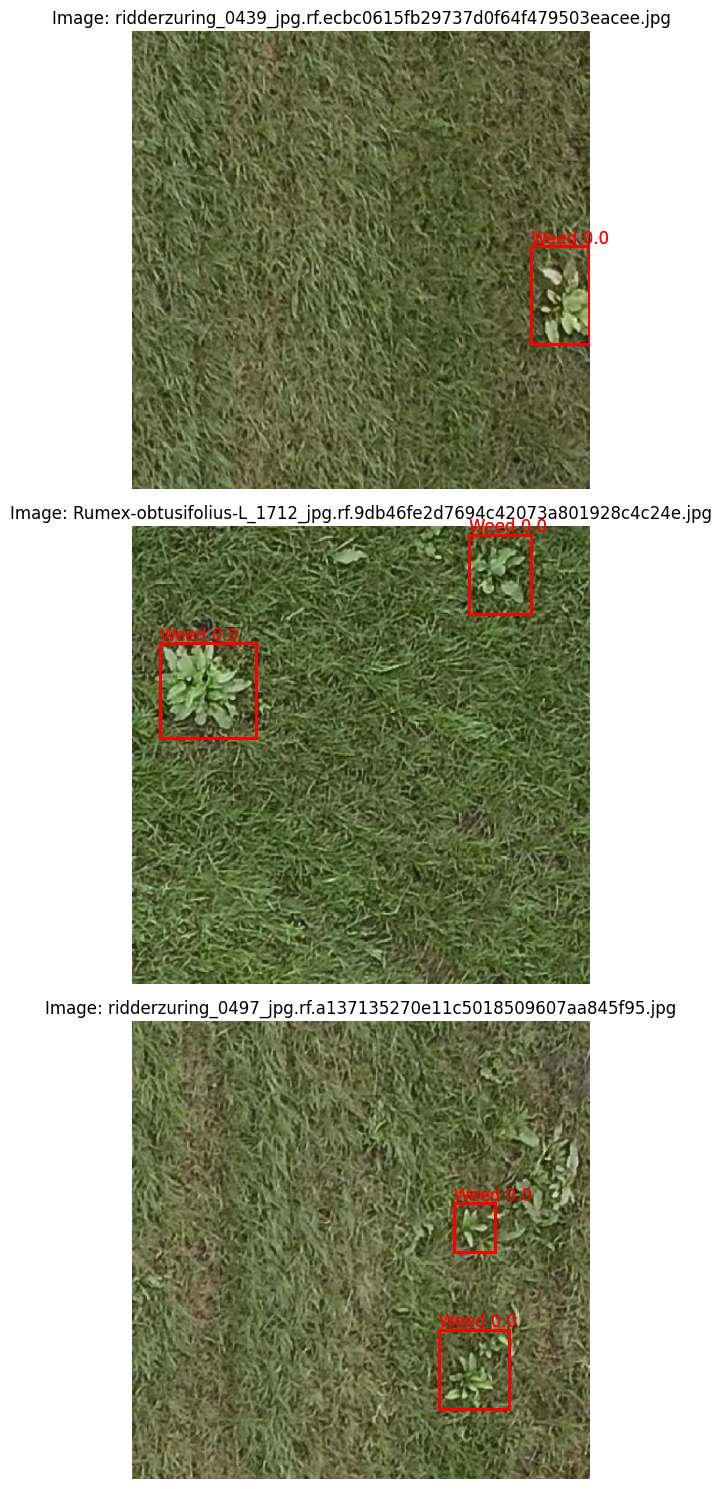


Visualisation du dataset de test:


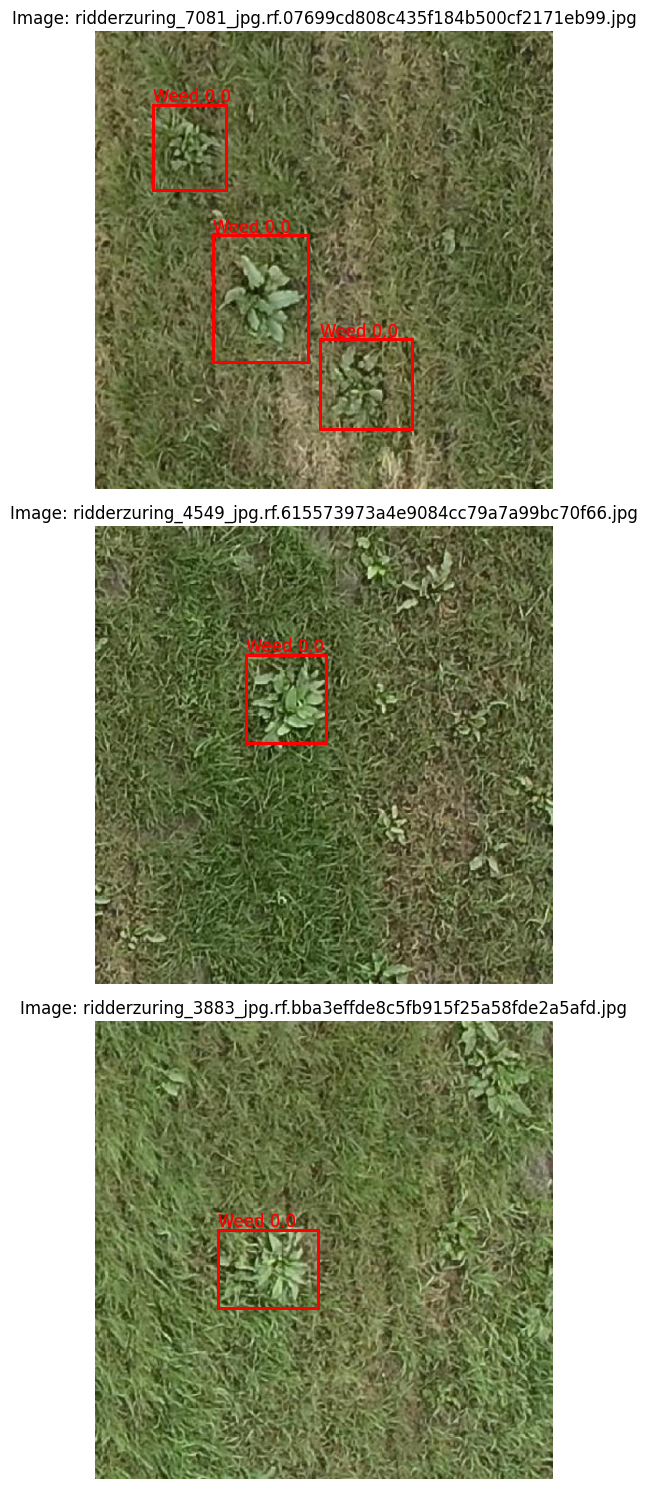

In [31]:
def visualize_yolo_dataset(data_path, num_samples=3):
    """
    Visualise les images et leurs annotations au format YOLO
    """
    # Charger quelques images aléatoires
    image_files = [f for f in os.listdir(data_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    selected_files = np.random.choice(image_files, min(num_samples, len(image_files)), replace=False)
    
    plt.figure(figsize=(15, 5*num_samples))
    
    for idx, img_file in enumerate(selected_files):
        # Charger l'image
        img_path = os.path.join(data_path, img_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Charger les annotations YOLO correspondantes
        txt_file = os.path.join(data_path, os.path.splitext(img_file)[0] + '.txt')
        
        plt.subplot(num_samples, 1, idx + 1)
        plt.imshow(img)
        
        if os.path.exists(txt_file):
            with open(txt_file, 'r') as f:
                lines = f.readlines()
                
            img_height, img_width = img.shape[:2]
            
            for line in lines:
                # Format YOLO: class x_center y_center width height
                class_id, x_center, y_center, width, height = map(float, line.strip().split())
                
                # Convertir les coordonnées normalisées en pixels
                x = int((x_center - width/2) * img_width)
                y = int((y_center - height/2) * img_height)
                w = int(width * img_width)
                h = int(height * img_height)
                
                # Dessiner le rectangle
                rect = patches.Rectangle(
                    (x, y), w, h,
                    linewidth=2,
                    edgecolor='r',
                    facecolor='none'
                )
                plt.gca().add_patch(rect)
                
                # Ajouter le label
                plt.text(x, y-5, f'Weed {class_id}', color='r', fontsize=12)
        
        plt.title(f'Image: {img_file}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Utilisation
print("Visualisation du dataset d'entraînement:")
visualize_yolo_dataset('yolo_dataset/train')

print("\nVisualisation du dataset de test:")
visualize_yolo_dataset('yolo_dataset/test')

In [32]:
def verify_yolo_conversion():
    """
    Vérifie la qualité de la conversion COCO vers YOLO
    """
    train_path = 'yolo_dataset/train'
    
    # Compter les fichiers
    img_files = [f for f in os.listdir(train_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    txt_files = [f for f in os.listdir(train_path) if f.endswith('.txt')]
    
    print(f"Statistiques de conversion:")
    print(f"Nombre d'images: {len(img_files)}")
    print(f"Nombre de fichiers d'annotation: {len(txt_files)}")
    
    # Vérifier quelques annotations
    sample_txt = np.random.choice(txt_files, min(5, len(txt_files)))
    print("\nExemples d'annotations YOLO:")
    for txt_file in sample_txt:
        with open(os.path.join(train_path, txt_file), 'r') as f:
            content = f.read().strip()
            print(f"\n{txt_file}:")
            print(content)

# Vérification
verify_yolo_conversion()

Statistiques de conversion:
Nombre d'images: 1661
Nombre de fichiers d'annotation: 1655

Exemples d'annotations YOLO:

ridderzuring_0626_jpg.rf.37b8193d46c9591aed4833a5abe9d2e8.txt:
0 0.0203125 0.295703125 0.040625 0.15390625
0 0.794140625 0.619140625 0.18515625 0.17578125
0 0.126171875 0.91328125 0.13671875 0.1703125
0 0.0203125 0.295703125 0.040625 0.15390625
0 0.794140625 0.619140625 0.18515625 0.17578125
0 0.126171875 0.91328125 0.13671875 0.1703125

Rumex-obtusifolius-L_2369_jpg.rf.840381f861daf5bbaea61515bfa60c7c.txt:
0 0.079296875 0.06015625 0.15859375 0.1203125
0 0.777734375 0.09296875 0.11796875 0.1703125
0 0.079296875 0.06015625 0.15859375 0.1203125
0 0.777734375 0.09296875 0.11796875 0.1703125

Rumex-obtusifolius-L_2284_jpg.rf.46697ac23f937a502785cd3698620bb4.txt:
0 0.21171875 0.29921875 0.1390625 0.1609375
0 0.21171875 0.29921875 0.1390625 0.1609375

Rumex-obtusifolius-L_2342_jpg.rf.db312661bbe97c8cb5f54372928daabe.txt:
0 0.052734375 0.96953125 0.10546875 0.0578125
0 0.0527

In [33]:
def clean_yolo_annotations(data_path):
    """
    Nettoie les annotations YOLO en supprimant les doublons
    """
    txt_files = [f for f in os.listdir(data_path) if f.endswith('.txt')]
    duplicates_found = 0
    files_cleaned = 0
    
    for txt_file in txt_files:
        file_path = os.path.join(data_path, txt_file)
        
        # Lire les annotations
        with open(file_path, 'r') as f:
            lines = f.readlines()
        
        # Convertir chaque ligne en tuple pour pouvoir utiliser set()
        unique_annotations = set()
        for line in lines:
            # Convertir la ligne en tuple de floats
            values = tuple(map(float, line.strip().split()))
            unique_annotations.add(values)
        
        # Si on a trouvé des doublons
        if len(unique_annotations) < len(lines):
            duplicates_found += len(lines) - len(unique_annotations)
            files_cleaned += 1
            
            # Réécrire le fichier sans les doublons
            with open(file_path, 'w') as f:
                for annotation in unique_annotations:
                    f.write(' '.join(map(str, annotation)) + '\n')
    
    print(f"Nettoyage terminé:")
    print(f"- {duplicates_found} annotations dupliquées supprimées")
    print(f"- {files_cleaned} fichiers nettoyés")
    
    return duplicates_found, files_cleaned

# Nettoyer les annotations dans les dossiers train et test
print("Nettoyage du dossier train:")
clean_yolo_annotations('yolo_dataset/train')

print("\nNettoyage du dossier test:")
clean_yolo_annotations('yolo_dataset/test')

# Vérifier les annotations après nettoyage
def verify_annotations_after_cleaning(data_path):
    """
    Vérifie qu'il n'y a plus de doublons dans les annotations
    """
    txt_files = [f for f in os.listdir(data_path) if f.endswith('.txt')]
    
    print(f"\nVérification des annotations dans {data_path}:")
    print(f"Nombre total de fichiers d'annotation: {len(txt_files)}")
    
    # Vérifier quelques exemples
    sample_files = np.random.choice(txt_files, min(3, len(txt_files)), replace=False)
    print("\nExemples d'annotations nettoyées:")
    
    for txt_file in sample_files:
        with open(os.path.join(data_path, txt_file), 'r') as f:
            content = f.readlines()
        print(f"\n{txt_file} ({len(content)} annotations):")
        for line in content:
            print(line.strip())

# Vérifier après nettoyage
verify_annotations_after_cleaning('yolo_dataset/train')
verify_annotations_after_cleaning('yolo_dataset/test')

Nettoyage du dossier train:
Nettoyage terminé:
- 4199 annotations dupliquées supprimées
- 1655 fichiers nettoyés

Nettoyage du dossier test:
Nettoyage terminé:
- 662 annotations dupliquées supprimées
- 244 fichiers nettoyés

Vérification des annotations dans yolo_dataset/train:
Nombre total de fichiers d'annotation: 1655

Exemples d'annotations nettoyées:

ridderzuring_2229_jpg.rf.4810c071b3381bce0cbf4dcfe4b95dd5.txt (1 annotations):
0.0 0.808203125 0.780078125 0.18515625 0.18515625

ridderzuring_0641_jpg.rf.f78d0da7d66b949c1a1c77fe8eee6bf9.txt (2 annotations):
0.0 0.54296875 0.639453125 0.1140625 0.09140625
0.0 0.624609375 0.287109375 0.09921875 0.10859375

ridderzuring_0331_jpg.rf.1c2857dcfe6e34242c2ec61a0e8425e3.txt (1 annotations):
0.0 0.193359375 0.436328125 0.18046875 0.16015625

Vérification des annotations dans yolo_dataset/test:
Nombre total de fichiers d'annotation: 244

Exemples d'annotations nettoyées:

ridderzuring_7142_jpg.rf.520a3836e53095672e4c9caa5df71d2c.txt (7 annota

In [5]:
# Load the COCO annotation file
with open(path + '/train/_annotations.coco.json', 'r') as f:
    coco_data = json.load(f)

# Convert COCO annotations to YOLO format
convert_to_yolo_format(coco_data, path + '/train', 'yolo_dataset/train')

train_path = 'yolo_dataset/train'

In [6]:
# Convert COCO annotations to YOLO format for test set
with open(path + '/test/_annotations.coco.json', 'r') as f:
    test_coco_data = json.load(f)

# Convert test annotations to YOLO format 
convert_to_yolo_format(test_coco_data, path + '/test', 'yolo_dataset/test')

test_path = 'yolo_dataset/test'

In [21]:
# Créer les dossiers YOLO s'ils n'existent pas
for dataset in ['train', 'test']:
    os.makedirs(f'yolo_dataset/{dataset}', exist_ok=True)

# Copier les images et créer les annotations pour chaque dataset
for dataset in ['train', 'test']:
    source_folder = os.path.join(path, dataset)
    target_folder = f'yolo_dataset/{dataset}'
    
    # Copier toutes les images
    for img_file in os.listdir(source_folder):
        if img_file.endswith(('.jpg', '.jpeg', '.png')):
            src_path = os.path.join(source_folder, img_file)
            dst_path = os.path.join(target_folder, img_file)
            shutil.copy2(src_path, dst_path)

# Maintenant, on peut exécuter le code original pour data.yaml et la création des fichiers txt
data_yaml = {
    'train': train_path,
    'val': test_path,
    'nc': 1,
    'names': ['weed']
}

with open('yolo_dataset/data.yaml', 'w') as f:
    yaml.dump(data_yaml, f)

# Pour chaque dataset (train et test)
for dataset in ['train', 'test']:
    img_path = f'yolo_dataset/{dataset}'
    
    # Lister tous les fichiers d'annotations (.txt)
    txt_files = [f for f in os.listdir(img_path) if f.endswith('.txt')]
    
    # Créer les chemins correspondants pour les images
    img_paths = []
    label_paths = []
    
    for txt_file in txt_files:
        base_name = os.path.splitext(txt_file)[0]
        # Vérifier si l'image correspondante existe
        for ext in ['.jpg', '.jpeg', '.png']:
            img_file = base_name + ext
            if os.path.exists(os.path.join(img_path, img_file)):
                img_paths.append(os.path.join(img_path, img_file))
                label_paths.append(os.path.join(img_path, txt_file))
                break
    
    # Écrire les chemins dans les fichiers
    with open(f'yolo_dataset/{dataset}_images.txt', 'w') as f:
        f.write('\n'.join(img_paths))
    
    with open(f'yolo_dataset/{dataset}_labels.txt', 'w') as f:
        f.write('\n'.join(label_paths))
    
    print(f"\nDataset {dataset}:")
    print(f"- Nombre de fichiers d'annotations: {len(txt_files)}")
    print(f"- Nombre de paires image-annotation: {len(img_paths)}")


Dataset train:
- Nombre de fichiers d'annotations: 1655
- Nombre de paires image-annotation: 1655

Dataset test:
- Nombre de fichiers d'annotations: 244
- Nombre de paires image-annotation: 244


In [24]:
# Obtenir le chemin absolu du projet
import os
current_dir = os.getcwd()

# Créer data.yaml avec les chemins absolus
data_yaml = {
    'train': os.path.join(current_dir, 'yolo_dataset/train'),  # chemin absolu vers train
    'val': os.path.join(current_dir, 'yolo_dataset/test'),     # chemin absolu vers test
    'nc': 1,  # nombre de classes
    'names': ['weed']  # nom des classes
}

# Écrire data.yaml
with open('yolo_dataset/data.yaml', 'w') as f:
    yaml.dump(data_yaml, f)

# Vérifier le contenu du fichier
with open('yolo_dataset/data.yaml', 'r') as f:
    print(f.read())

names:
- weed
nc: 1
train: /Users/oceanspiess/PycharmProjects/ml-cv/ml-cv-project/yolo_dataset/train
val: /Users/oceanspiess/PycharmProjects/ml-cv/ml-cv-project/yolo_dataset/test



In [28]:
# Vérifier le contenu du fichier data.yaml
with open('yolo_dataset/data.yaml', 'r') as f:
    content = yaml.safe_load(f)
    print("Configuration data.yaml:")
    print(f"- Train path: {content['train']}")
    print(f"- Val path: {content['val']}")
    print(f"- Number of classes: {content['nc']}")
    print(f"- Class names: {content['names']}")

Configuration data.yaml:
- Train path: /Users/oceanspiess/PycharmProjects/ml-cv/ml-cv-project/yolo_dataset/train
- Val path: /Users/oceanspiess/PycharmProjects/ml-cv/ml-cv-project/yolo_dataset/test
- Number of classes: 1
- Class names: ['weed']


In [30]:
# Charger le modèle YOLOv8
model = YOLO('yolov8n.pt')  # Charger YOLOv8n, le plus petit modèle

# Entraîner le modèle
results = model.train(
    data='yolo_dataset/data.yaml',  # Chemin vers le fichier data.yaml
    epochs=100,                     # Nombre d'époques
    imgsz=640,                     # Taille des images
    batch=16,                      # Taille du batch
    name='weed_detection'          # Nom de l'expérience
)

Ultralytics 8.3.51 🚀 Python-3.9.6 torch-2.0.1 CPU (Apple M3)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=yolo_dataset/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=weed_detection4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_wi

train: Scanning /Users/oceanspiess/PycharmProjects/ml-cv/ml-cv-project/yolo_dataset/train.cache... 1655 images, 6 backgrounds, 0 corrupt: 100%|██████████| 1661/1661 [00:00<?, ?it/s]

train: WARNING ⚠️ /Users/oceanspiess/PycharmProjects/ml-cv/ml-cv-project/yolo_dataset/train/Rumex-obtusifolius-L_0002_jpg.rf.d1ba7d1ebfc636466d5e1de576dafa0a.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /Users/oceanspiess/PycharmProjects/ml-cv/ml-cv-project/yolo_dataset/train/Rumex-obtusifolius-L_0004_jpg.rf.abe91960d17d8aeebb5261b53296123b.jpg: 4 duplicate labels removed
train: WARNING ⚠️ /Users/oceanspiess/PycharmProjects/ml-cv/ml-cv-project/yolo_dataset/train/Rumex-obtusifolius-L_0006_jpg.rf.6a82808dfd5d3107f4dcc30d05ea5dcd.jpg: 3 duplicate labels removed
train: WARNING ⚠️ /Users/oceanspiess/PycharmProjects/ml-cv/ml-cv-project/yolo_dataset/train/Rumex-obtusifolius-L_0007_jpg.rf.7726b2cd405d8ea243811ee040351947.jpg: 4 duplicate labels removed
train: WARNING ⚠️ /Users/oceanspiess/PycharmProjects/ml-cv/ml-cv-project/yolo_dataset/train/Rumex-obtusifolius-L_0008_jpg.rf.ae948af6f4148417e36c16465c062576.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /Users/oceanspiess/PycharmProjec


val: Scanning /Users/oceanspiess/PycharmProjects/ml-cv/ml-cv-project/yolo_dataset/test.cache... 244 images, 1 backgrounds, 0 corrupt: 100%|██████████| 245/245 [00:00<?, ?it/s]

val: WARNING ⚠️ /Users/oceanspiess/PycharmProjects/ml-cv/ml-cv-project/yolo_dataset/test/ridderzuring_3109_jpg.rf.b8e99770acf95370b238f2af2a71f5a3.jpg: 8 duplicate labels removed
val: WARNING ⚠️ /Users/oceanspiess/PycharmProjects/ml-cv/ml-cv-project/yolo_dataset/test/ridderzuring_3123_jpg.rf.dec89676b33f976690aabf25128a32ae.jpg: 9 duplicate labels removed
val: WARNING ⚠️ /Users/oceanspiess/PycharmProjects/ml-cv/ml-cv-project/yolo_dataset/test/ridderzuring_3126_jpg.rf.8980b3ae3ec4ecd023aab5bc54c26089.jpg: 7 duplicate labels removed
val: WARNING ⚠️ /Users/oceanspiess/PycharmProjects/ml-cv/ml-cv-project/yolo_dataset/test/ridderzuring_3128_jpg.rf.3df60a441016955fbf62fc335db58f9d.jpg: 3 duplicate labels removed
val: WARNING ⚠️ /Users/oceanspiess/PycharmProjects/ml-cv/ml-cv-project/yolo_dataset/test/ridderzuring_3129_jpg.rf.d376edabc61dc552b7f6671377a0ec98.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /Users/oceanspiess/PycharmProjects/ml-cv/ml-cv-project/yolo_dataset/test/ridderzuring_313

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to /Users/oceanspiess/PycharmProjects/ml-cv/runs/detect/weed_detection4
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/104 [00:00<?, ?it/s]


TypeError: expected np.ndarray (got numpy.ndarray)

# CNN Model (to do later)

## 3. Image Preprocessing Pipeline
Our preprocessing function performs several crucial steps:
1. **Image Loading**: Reads images from the specified folder
2. **Color Space Conversion**: Converts from BGR to RGB color space
3. **Resizing**: Standardizes all images to 320x320 pixels
4. **Normalization**: Scales pixel values to range [0,1]
5. **ID Extraction**: Maintains image identification for tracking

This standardization is crucial for:
- Ensuring consistent input dimensions for our neural network
- Reducing memory usage
- Improving training efficiency

In [8]:
def create_data_generator_with_bbox(data_folder, coco_annotations, target_size=(320, 320), batch_size=32):
    """
    Crée un générateur qui augmente à la fois les images et leurs bounding boxes
    """
    # Obtenir la liste des fichiers images
    image_files = [f for f in os.listdir(data_folder) if f.endswith('.jpg')]
    
    # Créer un mapping des images vers leurs annotations
    image_to_bbox = {}
    for ann in coco_annotations['annotations']:
        img_id = ann['image_id']
        img_info = next(img for img in coco_annotations['images'] if img['id'] == img_id)
        img_name = img_info['file_name']
        if img_name not in image_to_bbox:
            image_to_bbox[img_name] = []
        image_to_bbox[img_name].append({
            'bbox': ann['bbox'],
            'category_id': ann['category_id']
        })

    def get_image_bboxes(img_file):
        """Récupère les bounding boxes pour une image donnée"""
        bboxes = image_to_bbox.get(img_file, [])
        return [(bbox['bbox'] + [bbox['category_id']]) for bbox in bboxes]

    def augment_bbox(image, bboxes, category_ids):
        # Applique les transformations à l'image avec les labels
        augmented = transform(
            image=image,
            bboxes=bboxes,
            category_ids=category_ids
        )
        return augmented['image'], augmented['bboxes']
    
    # Création du pipeline d'augmentation avec albumentations
    transform = A.Compose([
        A.RandomRotate90(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.Resize(target_size[0], target_size[1]),
    ], bbox_params=A.BboxParams(
        format='coco',
        label_fields=['category_ids']  # Spécifie le champ pour les labels
    ))

    def generator():
        while True:
            # Charge les images et leurs annotations par batch
            for i in range(0, len(image_files), batch_size):
                batch_images = []
                batch_bboxes = []
                batch_files = image_files[i:i+batch_size]
                
                for img_file in batch_files:
                    # Charge l'image
                    image = cv2.imread(os.path.join(data_folder, img_file))
                    if image is None:
                        continue
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    
                    # Récupère les bounding boxes pour cette image
                    img_bboxes = get_image_bboxes(img_file)
                    
                    if img_bboxes:  # Si l'image a des bounding boxes
                        # Sépare les coordonnées des bboxes et les catégories
                        bboxes = [bbox[:4] for bbox in img_bboxes]
                        category_ids = [int(bbox[4]) for bbox in img_bboxes]
                        
                        # Applique l'augmentation
                        try:
                            aug_image, aug_bboxes = augment_bbox(
                                image=image,
                                bboxes=bboxes,
                                category_ids=category_ids
                            )
                            # Combine les bboxes augmentées avec leurs catégories
                            aug_bboxes = [list(bbox) + [cat_id] for bbox, cat_id in zip(aug_bboxes, category_ids)]
                        except ValueError as e:
                            print(f"Erreur lors de l'augmentation de {img_file}: {e}")
                            aug_image = image
                            aug_bboxes = img_bboxes
                    else:
                        aug_image = image
                        aug_bboxes = []
                    
                    batch_images.append(aug_image)
                    batch_bboxes.append(aug_bboxes)
                
                if batch_images:  # Vérifie qu'il y a des images dans le batch
                    yield np.array(batch_images), batch_bboxes

    return generator()

In [9]:
# Chargement des annotations COCO
with open(path + '/train/_annotations.coco.json', 'r') as f:
    coco_data = json.load(f)

# Création des générateurs avec gestion des bounding boxes
train_generator = create_data_generator_with_bbox(
    data_folder=path + '/train',
    coco_annotations=coco_data,
    target_size=(320, 320),
    batch_size=32
)

In [10]:
def visualize_augmented_data(generator, coco_data, num_samples=3):
    """
    Visualise les images augmentées avec leurs bounding boxes
    """
    # Créer le mapping des catégories
    category_id_to_name = {cat['id']: cat['name'] for cat in coco_data['categories']}
    
    plt.figure(figsize=(15, 5*num_samples))
    
    for i in range(num_samples):
        # Récupérer une batch d'images et annotations augmentées
        image_batch, bbox_batch = next(generator)
        
        # Prendre la première image de la batch
        img = image_batch[0]
        bboxes = bbox_batch[0]
        
        # Afficher l'image augmentée
        plt.subplot(num_samples, 1, i + 1)
        plt.title('Image augmentée')
        plt.imshow(img)
        
        # Dessiner les bounding boxes
        for bbox in bboxes:
            x, y, w, h = bbox[:4]
            category_id = int(bbox[4])
            
                # Créer le rectangle
            rect = patches.Rectangle(
                (x*img.shape[1], y*img.shape[0]),
                w*img.shape[1], h*img.shape[0],
                linewidth=2,
                edgecolor='r',
                facecolor='none'
            )
            plt.gca().add_patch(rect)
                
            # Ajouter le label
            category_name = category_id_to_name[category_id]
            plt.text(x*img.shape[1], y*img.shape[0]-5,
                    category_name, color='r')
            
        plt.axis('off')
  
    
    plt.tight_layout()
    plt.show()

In [11]:
# Visualize some augmented samples
visualize_augmented_data(train_generator, coco_data, num_samples=3)


/var/folders/56/smjnlmnd71b4_qpkf6gjxhv00000gn/T/ipykernel_72449/2874075995.py:46: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


ValueError: Image size of 96255x97332 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1500x1500 with 3 Axes>

In [12]:
def create_data_generator(data_folder, target_size=(320, 320), batch_size=32):
    """
    Creates and configures an image data generator with augmentation.
    
    Args:
        data_folder (str): Path to the dataset folder
        target_size (tuple): Target size for the images (height, width)
        batch_size (int): Number of images per batch
        
    Returns:
        generator: Configured data generator
    """

    # Create a DataFrame with image paths
    image_files = [f for f in os.listdir(data_folder) if f.endswith('.jpg')]
    
    # Create DataFrame with full paths
    df = pd.DataFrame({
        'filename': image_files,
        # Since we're doing object detection, we don't need class labels here
        # but the API requires a y_col, so we'll create a dummy one
        'label': [1] * len(image_files)  
    })

    # 1. Create image generator with augmentations
    datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # 2. Create data generator from folder
    generator = datagen.flow_from_dataframe(
        dataframe=df,
        directory=data_folder,
        x_col='filename',
        y_col='label',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='raw',  
        shuffle=True
    )

    return generator

In [13]:
# Training data generator
train_folder = path + "/train"
train_generator = create_data_generator(data_folder=train_folder)

# Test data generator 
test_folder = path + "/test"
test_generator = create_data_generator(data_folder=test_folder)


Found 1661 validated image filenames.
Found 245 validated image filenames.


## COCO Format Analysis
The dataset uses the COCO (Common Objects in Context) format, which is a standard for object detection tasks. We analyze:
- Total number of images in the dataset
- Number of object annotations
- Number of weed categories
- Distribution of annotations per image
- Basic image metadata (dimensions, file names)

This analysis helps us understand:
- The scale of our dataset
- The complexity of our detection task
- Potential class imbalance issues

In [14]:
# Load and explore the COCO annotations
import json

# Load the COCO annotation file
with open(path + '/train/_annotations.coco.json', 'r') as f:
    coco_data = json.load(f)

# Print basic dataset information
print("Dataset Information:")
print(f"Number of images: {len(coco_data['images'])}")
print(f"Number of annotations: {len(coco_data['annotations'])}")
print(f"Number of categories: {len(coco_data['categories'])}\n")

# Print category information
print("Categories:")
for category in coco_data['categories']:
    print(f"ID: {category['id']}, Name: {category['name']}")

# Get some statistics about annotations per image
annotations_per_image = {}
for ann in coco_data['annotations']:
    img_id = ann['image_id']
    if img_id not in annotations_per_image:
        annotations_per_image[img_id] = 0
    annotations_per_image[img_id] += 1

# Calculate and print annotation statistics
num_annotations = list(annotations_per_image.values())
print(f"\nAnnotation Statistics:")
print(f"Average annotations per image: {sum(num_annotations)/len(num_annotations):.2f}")
print(f"Max annotations in a single image: {max(num_annotations)}")
print(f"Min annotations in a single image: {min(num_annotations)}")

# Print sample image information
print("\nSample Image Information:")
for img in coco_data['images'][:3]:  # Show first 3 images
    print(f"ID: {img['id']}")
    print(f"File name: {img['file_name']}")
    print(f"Width: {img['width']}, Height: {img['height']}")
    print()


Dataset Information:
Number of images: 1661
Number of annotations: 4199
Number of categories: 2

Categories:
ID: 0, Name: grass-weeds
ID: 1, Name: 0 ridderzuring

Annotation Statistics:
Average annotations per image: 2.54
Max annotations in a single image: 19
Min annotations in a single image: 1

Sample Image Information:
ID: 0
File name: Rumex-obtusifolius-L_1703_jpg.rf.00ce9f9ea755f686d01d88767ff162ee.jpg
Width: 640, Height: 640

ID: 1
File name: ridderzuring_0981_jpg.rf.00938fc387bb7acbdd49a94a987fa58c.jpg
Width: 640, Height: 640

ID: 2
File name: Rumex-obtusifolius-L_0194_jpg.rf.00065c173713e91bdc5e600a761fa880.jpg
Width: 640, Height: 640



## Data Visualization
We implement a visualization function to:
- Display original images with their bounding box annotations
- Show category labels for each detected weed
- Verify the accuracy of our annotations
- Understand the visual characteristics of our dataset

This visual inspection helps us:
- Validate annotation quality
- Understand weed positioning and context
- Identify potential challenges for our model

In [15]:
# Function to visualize an image with its annotations
def visualize_annotations(image_id):
    # Get image details
    img_details = image_id_to_details[image_id]
    img_path = os.path.join(path + '/train', 
                           img_details['file_name'])
    
    # Read the image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Create figure and axes
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(img)
    
    # Get annotations for this image
    annotations = image_to_annotations.get(image_id, [])
    
    # Draw each annotation
    for ann in annotations:
        # Get the bounding box coordinates
        x, y, w, h = ann['bbox']
        
        # Create a Rectangle patch
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
        
        # Add the patch to the Axes
        ax.add_patch(rect)
        
        # Add category label
        category_name = category_id_to_name[ann['category_id']]
        plt.text(x, y-5, category_name, color='r', fontsize=12)
    
    plt.title(f'Image ID: {image_id} - {img_details["file_name"]}')
    plt.axis('off')
    plt.show()

Visualizing examples of annotated images:


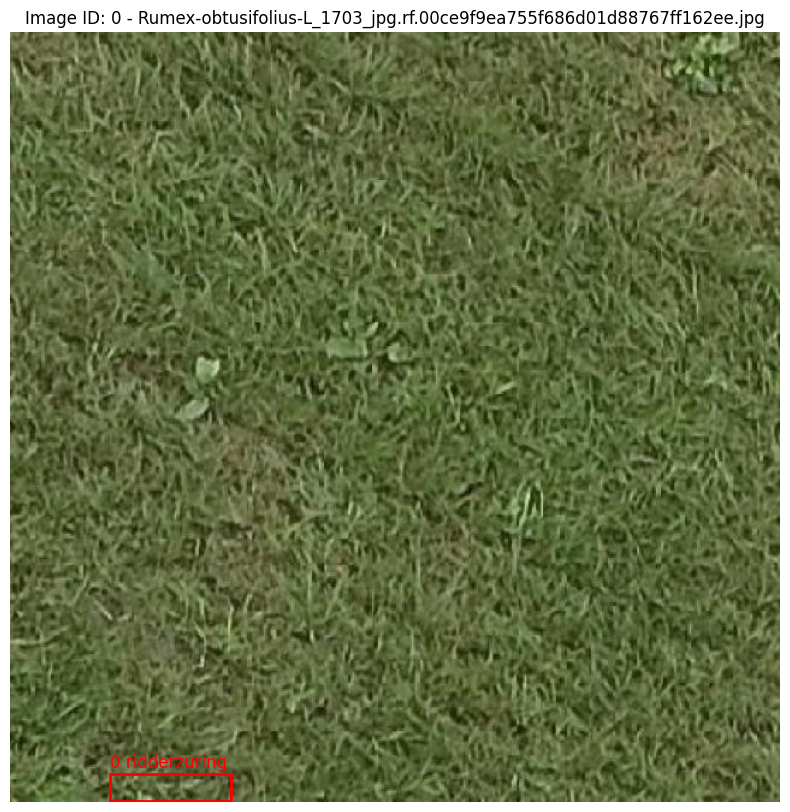

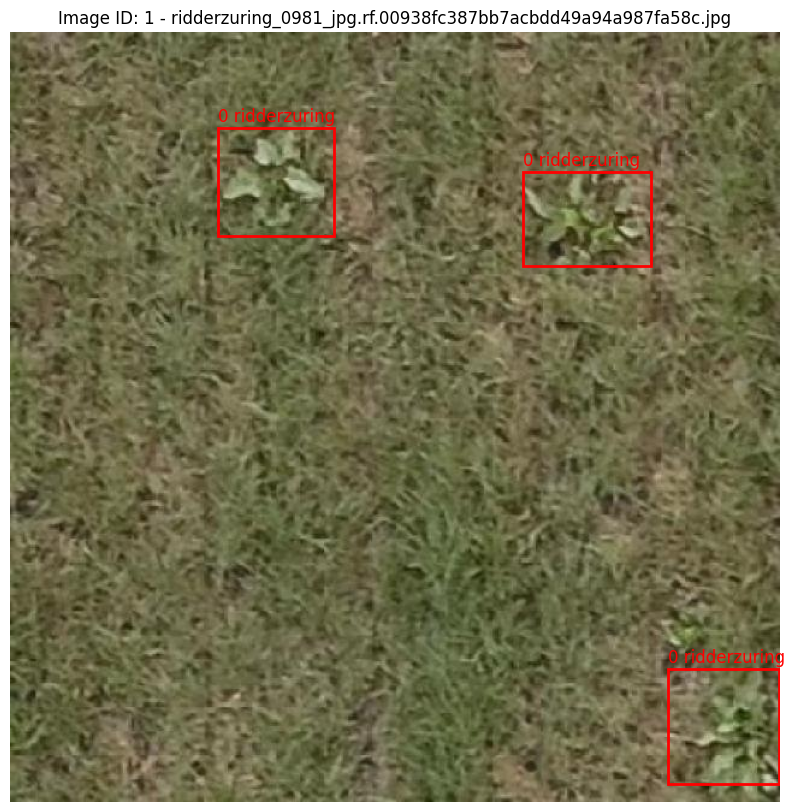

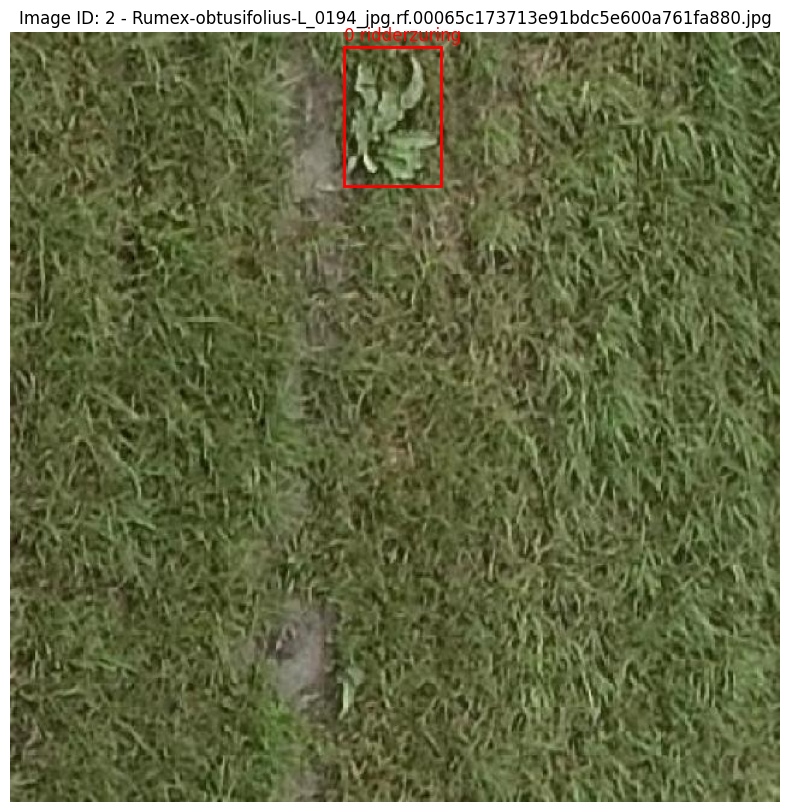


Bounding Box Statistics:
Average bounding box width: 91.73 pixels
Average bounding box height: 97.25 pixels
Average bounding box area: 9487.40 square pixels
Number of total annotations: 4199


In [16]:
# Create a mapping from image_id to annotations
image_to_annotations = {}
for ann in coco_data['annotations']:
    img_id = ann['image_id']
    if img_id not in image_to_annotations:
        image_to_annotations[img_id] = []
    image_to_annotations[img_id].append(ann)

# Create a mapping from image_id to image details
image_id_to_details = {img['id']: img for img in coco_data['images']}

# Create a mapping from category_id to category name
category_id_to_name = {cat['id']: cat['name'] for cat in coco_data['categories']}

# Visualize a few example images
print("Visualizing examples of annotated images:")
for image_id in list(image_to_annotations.keys())[:3]:  # Show first 3 images
    visualize_annotations(image_id)

# Print some detailed statistics about bounding boxes
print("\nBounding Box Statistics:")
widths = []
heights = []
areas = []

for ann in coco_data['annotations']:
    x, y, w, h = ann['bbox']
    widths.append(w)
    heights.append(h)
    areas.append(w * h)

print(f"Average bounding box width: {sum(widths)/len(widths):.2f} pixels")
print(f"Average bounding box height: {sum(heights)/len(heights):.2f} pixels")
print(f"Average bounding box area: {sum(areas)/len(areas):.2f} square pixels")
print(f"Number of total annotations: {len(areas)}")


## Label Processing
The label creation process involves:
- Mapping image filenames to their COCO IDs
- Extracting relevant annotations for each image
- Converting annotations into a format suitable for model training
- Handling cases where images might lack annotations

This step is crucial for:
- Preparing our ground truth data
- Ensuring proper model training
- Maintaining the connection between images and their annotations

In [17]:
def create_labels_from_annotations(coco_data, image_filenames):
    # Create a mapping from filename to image ID
    filename_to_id = {img['file_name'].split('.')[0]: img['id'] 
                     for img in coco_data['images']}
    
    labels = []
    for filename in image_filenames:
        # Get the corresponding COCO image ID
        image_id = filename_to_id.get(filename)
        if image_id is not None:
            # Get annotations for this image
            annotations = [ann for ann in coco_data['annotations'] 
                         if ann['image_id'] == image_id]
            labels.append(annotations)
        else:
            # If no annotations found, append an empty list
            labels.append([])
    
    return labels

# Now try creating the labels again
train_labels = create_labels_from_annotations(coco_data, )
test_labels = create_labels_from_annotations(coco_data, test_image_ids)

TypeError: create_labels_from_annotations() missing 1 required positional argument: 'image_filenames'

## Model Architecture Design
Our initial model implements:
- Data augmentation techniques to increase training data variety
- A sequential CNN architecture for object detection
- Multiple convolutional and pooling layers for feature extraction
- Dense layers for final predictions

Data augmentation includes:
- Horizontal flipping for orientation invariance
- Slight rotation to handle tilted weeds
- Zoom variations to handle size differences

This architecture serves as our baseline model before moving to more sophisticated approaches.

In [ ]:
# 1. Conversion des labels en format approprié
def convert_labels_to_array(labels, num_categories):
    num_samples = len(labels)
    # Format: [x, y, w, h, one_hot_encoded_categories]
    label_array = np.zeros((num_samples, 4 + num_categories))
    
    for i, annotation_list in enumerate(labels):
        if annotation_list:  # Si il y a des annotations
            ann = annotation_list[0]  # Prendre la première annotation
            # Coordonnées de la bbox
            label_array[i, :4] = ann['bbox']
            # One-hot encoding de la catégorie
            label_array[i, 4 + ann['category_id']] = 1
    
    return label_array

# 2. Conversion des labels
num_categories = len(coco_data['categories'])
train_labels_array = convert_labels_to_array(train_labels, num_categories)
test_labels_array = convert_labels_to_array(test_labels, num_categories)

In [ ]:
def diagnostic_data(train_images, train_labels_array, test_images, test_labels_array):
    print("=== DIAGNOSTIC DES DONNÉES ===\n")
    
    # 1. Format des données d'entrée
    print("Format des données:")
    print(f"Train images shape: {train_images.shape}")
    print(f"Train labels shape: {train_labels_array.shape}")
    print(f"Test images shape: {test_images.shape}")
    print(f"Test labels shape: {test_labels_array.shape}\n")
    
    # 2. Valeurs des images
    print("Statistiques des images:")
    print(f"Train images - min: {train_images.min():.4f}, max: {train_images.max():.4f}, mean: {train_images.mean():.4f}")
    print(f"Test images - min: {test_images.min():.4f}, max: {test_images.max():.4f}, mean: {test_images.mean():.4f}\n")
    
    # 3. Analyse des labels
    print("Analyse des labels:")
    # Séparer bbox et classes
    train_bbox = train_labels_array[:, :4]
    train_classes = train_labels_array[:, 4:]
    
    print("\nBounding boxes (premières 4 colonnes):")
    print(f"Min: {train_bbox.min():.4f}")
    print(f"Max: {train_bbox.max():.4f}")
    print(f"Mean: {train_bbox.mean():.4f}")
    print(f"Nombre de zéros: {(train_bbox == 0).sum()}")
    
    print("\nClasses (colonnes restantes):")
    print(f"Nombre de classes uniques: {len(np.unique(np.argmax(train_classes, axis=1)))}")
    print(f"Distribution des classes: {np.bincount(np.argmax(train_classes, axis=1))}")
    print(f"Somme par ligne (devrait être 1): {np.unique(train_classes.sum(axis=1))}")
    
    # 4. Vérification des NaN et Inf
    print("\nVérification des valeurs problématiques:")
    print(f"NaN dans train_images: {np.isnan(train_images).any()}")
    print(f"NaN dans train_labels: {np.isnan(train_labels_array).any()}")
    print(f"Inf dans train_images: {np.isinf(train_images).any()}")
    print(f"Inf dans train_labels: {np.isinf(train_labels_array).any()}")

# Pour une loss typique, les valeurs devraient être:
# - Entre 0 et 10 pour une loss combinée (classification + régression)
# - Diminuer progressivement pendant l'entraînement
# - Relativement stables entre train et validation

# Utilisation:
diagnostic_data(train_images, train_labels_array, test_images, test_labels_array)

=== DIAGNOSTIC DES DONNÉES ===

Format des données:
Train images shape: (1661, 320, 320, 3)
Train labels shape: (1661, 6)
Test images shape: (245, 320, 320, 3)
Test labels shape: (245, 6)

Statistiques des images:
Train images - min: 0.0000, max: 1.0000, mean: 0.3549
Test images - min: 0.0000, max: 0.9882, mean: 0.3559

Analyse des labels:

Bounding boxes (premières 4 colonnes):
Min: 0.0000
Max: 637.0000
Mean: 168.7284
Nombre de zéros: 465

Classes (colonnes restantes):
Nombre de classes uniques: 2
Distribution des classes: [   6 1655]
Somme par ligne (devrait être 1): [0. 1.]

Vérification des valeurs problématiques:
NaN dans train_images: False
NaN dans train_labels: False
Inf dans train_images: False
Inf dans train_labels: False


In [ ]:
def custom_loss(y_true, y_pred):
    # Séparation bbox et classification
    bbox_true = y_true[:, :4]
    bbox_pred = y_pred[:, :4]
    class_true = y_true[:, 4]  # Maintenant un seul scalaire
    class_pred = y_pred[:, 4]  # Maintenant un seul scalaire
    
    # Loss bbox (maintenant avec données normalisées)
    bbox_loss = tf.reduce_mean(tf.square(bbox_true - bbox_pred))
    
    # Loss classification avec binary_crossentropy au lieu de categorical_crossentropy
    class_loss = tf.keras.losses.binary_crossentropy(
        class_true, 
        tf.nn.sigmoid(class_pred)  # sigmoid au lieu de softmax
    )
    
    # Pondération des deux losses
    return bbox_loss + 2.0 * class_loss


In [ ]:
# 2. AJOUTER ICI : Suppression des échantillons de classe 0
print("Avant filtrage :")
print(f"Nombre d'images d'entraînement : {len(train_images)}")
print(f"Distribution des classes : {np.bincount(np.argmax(train_labels_array[:, 4:], axis=1))}\n")

# Identifier les indices de la classe majoritaire (classe 1)
majority_indices = np.where(np.argmax(train_labels_array[:, 4:], axis=1) == 1)[0]

# Filtrer les images et labels
train_images = train_images[majority_indices]
train_labels_array = train_labels_array[majority_indices]

# Supprimer la colonne de la classe 0 (garder seulement les coordonnées bbox et la classe 1)
train_labels_array = train_labels_array[:, [0,1,2,3,5]]

# Faire la même chose pour le test set
test_majority_indices = np.where(np.argmax(test_labels_array[:, 4:], axis=1) == 1)[0]
test_images = test_images[test_majority_indices]
test_labels_array = test_labels_array[test_majority_indices]
test_labels_array = test_labels_array[:, [0,1,2,3,5]]

print("Après filtrage :")
print(f"Nombre d'images d'entraînement : {len(train_images)}")
print(f"Shape des labels : {train_labels_array.shape}")

Avant filtrage :
Nombre d'images d'entraînement : 1661
Distribution des classes : [   6 1655]

Après filtrage :
Nombre d'images d'entraînement : 1655
Shape des labels : (1655, 5)


In [ ]:
# Solution : Normalisation des bounding boxes
def normalize_bbox(labels_array, img_size=(320, 320)):
    normalized_labels = labels_array.copy()
    # Normaliser x et width par la largeur de l'image
    normalized_labels[:, 0] = labels_array[:, 0] / img_size[0]
    normalized_labels[:, 2] = labels_array[:, 2] / img_size[0]
    # Normaliser y et height par la hauteur de l'image
    normalized_labels[:, 1] = labels_array[:, 1] / img_size[1]
    normalized_labels[:, 3] = labels_array[:, 3] / img_size[1]
    return normalized_labels

# Appliquer la normalisation
train_labels_array = normalize_bbox(train_labels_array)
test_labels_array = normalize_bbox(test_labels_array)

In [ ]:
# 3. Définition du modèle CNN basique
model_basic = Sequential([
    # Première couche de convolution
    Conv2D(32, (3, 3), activation='relu', input_shape=(320, 320, 3)),
    MaxPooling2D((2, 2)),
    
    # Deuxième couche de convolution
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    # Troisième couche de convolution
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    # Quatrième couche de convolution
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    # Aplatissement
    Flatten(),
    
    # Couches denses
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(5)  # 4 pour bbox + 1 pour la classe restante (au lieu de 6)
])

In [ ]:
# 4. Compilation du modèle
model_basic.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=custom_loss,
    metrics=[
        tf.keras.metrics.MeanSquaredError(name='bbox_mse'),
        tf.keras.metrics.BinaryAccuracy(name='class_accuracy')  
    ]
)

# 5. Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

# 6. Entraînement du modèle
history_basic = model_basic.fit(
    train_images,
    train_labels_array,  # Utilisation du nouveau format
    validation_split=0.2,
    epochs=50,
    batch_size=16,
    callbacks=[early_stopping, reduce_lr],
    shuffle=True
)

Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 57s 666ms/step - bbox_mse: 2.2437 - class_accuracy: 0.2122 - loss: 0.6561 - val_bbox_mse: 7.9265 - val_class_accuracy: 0.2012 - val_loss: 0.1809 - learning_rate: 0.0010
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 57s 686ms/step - bbox_mse: 6.3014 - class_accuracy: 0.2088 - loss: 0.2049 - val_bbox_mse: 8.0423 - val_class_accuracy: 0.2012 - val_loss: 0.1719 - learning_rate: 0.0010
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 56s 669ms/step - bbox_mse: 6.8929 - class_accuracy: 0.2092 - loss: 0.2036 - val_bbox_mse: 6.3021 - val_class_accuracy: 0.2012 - val_loss: 0.1951 - learning_rate: 0.0010
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 52s 620ms/step - bbox_mse: 8.2118 - class_accuracy: 0.2079 - loss: 0.1897 - val_bbox_mse: 9.7066 - val_class_accuracy: 0.2012 - val_loss: 0.1707 - learning_rate: 0.0010
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 55s 658ms/step - bbox_mse: 9.9519 - class_accuracy: 0.2029 - loss: 0.1919 - val_bbox_mse: 8.8072 - val_class_accuracy: 0.2012 - val_lo

In [ ]:
# 1. Fonction de visualisation modifiée
def visualize_predictions(model, images, labels, num_samples=5):
    # Sélectionner des échantillons aléatoires
    indices = np.random.choice(len(images), num_samples, replace=False)
    
    for idx in indices:
        image = images[idx]
        true_label = labels[idx]
        pred = model.predict(np.expand_dims(image, axis=0))[0]
        
        # Extraire les coordonnées
        true_bbox = true_label[:4]
        pred_bbox = pred[:4]
        
        # Afficher l'image
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        # Rectangle vrai (vert)
        plt.gca().add_patch(plt.Rectangle((true_bbox[0]*320, true_bbox[1]*320),
                                        true_bbox[2]*320, true_bbox[3]*320,
                                        fill=False, color='g', linewidth=2))
        plt.title('Vérité terrain')
        
        plt.subplot(1, 2, 2)
        plt.imshow(image)
        # Rectangle prédit (rouge)
        plt.gca().add_patch(plt.Rectangle((pred_bbox[0]*320, pred_bbox[1]*320),
                                        pred_bbox[2]*320, pred_bbox[3]*320,
                                        fill=False, color='r', linewidth=2))
        plt.title(f'Prédiction (Conf: {pred[4]:.2f})')
        plt.show()

In [ ]:
def evaluate_model(model, test_images, test_labels):
    try:
        print("Début des prédictions...")
        predictions = model.predict(test_images, verbose=0)  # Désactive la barre de progression
        
        print("\nCalcul des métriques...")
        # Métriques pour les bounding boxes
        bbox_mse = np.mean(np.square(test_labels[:, :4] - predictions[:, :4]))
        bbox_mae = np.mean(np.abs(test_labels[:, :4] - predictions[:, :4]))
        
        # Métriques pour la classification
        y_true = test_labels[:, 4]
        y_pred = (predictions[:, 4] > 0.5).astype(int)  # Seuil à 0.5
        
        # Calculer IoU (Intersection over Union)
        def calculate_iou(box1, box2):
            try:
                x1 = max(box1[0], box2[0])
                y1 = max(box1[1], box2[1])
                x2 = min(box1[0] + box1[2], box2[0] + box2[2])
                y2 = min(box1[1] + box1[3], box2[1] + box2[3])
                
                intersection = max(0, x2 - x1) * max(0, y2 - y1)
                area1 = box1[2] * box1[3]
                area2 = box2[2] * box2[3]
                union = area1 + area2 - intersection
                
                return intersection / (union + 1e-6)
            except Exception as e:
                print(f"Erreur dans le calcul IoU: {e}")
                return 0
        
        # Calculer IoU moyen avec gestion d'erreurs
        ious = []
        for i in range(len(test_labels)):
            try:
                iou = calculate_iou(test_labels[i, :4], predictions[i, :4])
                ious.append(iou)
            except Exception as e:
                print(f"Erreur pour l'échantillon {i}: {e}")
                ious.append(0)
        
        mean_iou = np.mean(ious)
        
        print("\nÉvaluation du modèle:")
        print(f"MSE Bounding Box: {bbox_mse:.4f}")
        print(f"MAE Bounding Box: {bbox_mae:.4f}")
        print(f"IoU moyen: {mean_iou:.4f}")
        print(f"Précision de détection (IoU > 0.5): {np.mean(np.array(ious) > 0.5):.4f}")
        
        # Afficher quelques statistiques supplémentaires
        print("\nStatistiques des prédictions:")
        print(f"Shape des prédictions: {predictions.shape}")
        print(f"Min/Max bbox prédites: {predictions[:, :4].min():.4f}/{predictions[:, :4].max():.4f}")
        print(f"Min/Max scores de classification: {predictions[:, 4].min():.4f}/{predictions[:, 4].max():.4f}")
        
        return {
            'bbox_mse': bbox_mse,
            'bbox_mae': bbox_mae,
            'mean_iou': mean_iou,
            'detection_accuracy': np.mean(np.array(ious) > 0.5)
        }
        
    except Exception as e:
        print(f"Erreur dans l'évaluation: {e}")
        print(f"Shape des données de test: {test_images.shape}")
        print(f"Shape des labels de test: {test_labels.shape}")
        return None

# Utilisation
print("\nÉvaluation détaillée:")
metrics = evaluate_model(model_basic, test_images, test_labels_array)


Évaluation détaillée:
Début des prédictions...
Erreur dans l'évaluation: local variable 'batch_outputs' referenced before assignment
Shape des données de test: (0, 320, 320, 3)
Shape des labels de test: (0, 5)


2024-12-15 18:55:32.554028: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
# 3. Utilisation

print("\nÉvaluation détaillée:")
metrics = evaluate_model(model_basic, test_images, test_labels_array)


Évaluation détaillée:


2024-12-15 18:54:40.808592: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/Users/oceanspiess/PycharmProjects/ml-cv/ml-cv-project/.venv/lib/python3.9/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


ValueError: math domain error

## code i ll maybe use 

Aucune image de classe 0 trouvée!
